# Capture Spectrum

Below we will generate plots for both the real and simulated capture spectra. If you are re-generating the plots, please be patient, as both load large amounts of data.

## Measured Spectra

*(If you are not interested in the code itself, you can collapse it by selecting the cell and then clicking on the bar to its left. You will still be able to run it and view its output.)*

Measured spectra and reconstructed PuBe rate.  
First, the reconstructed spetra were calculated by dividing the measured count rates by the livetimes and estimated effficiences after applying quality cuts. 
Then, the background rate was subtracted from the overall rate, leaving the events due to the PuBe source.

A simulated measured spectrum was built using Geant4. 
We then compared this to our actual data using MCMC sampling (`fitting` directory) as well as a simpler integral method (`Integral_Method.ipynb`).

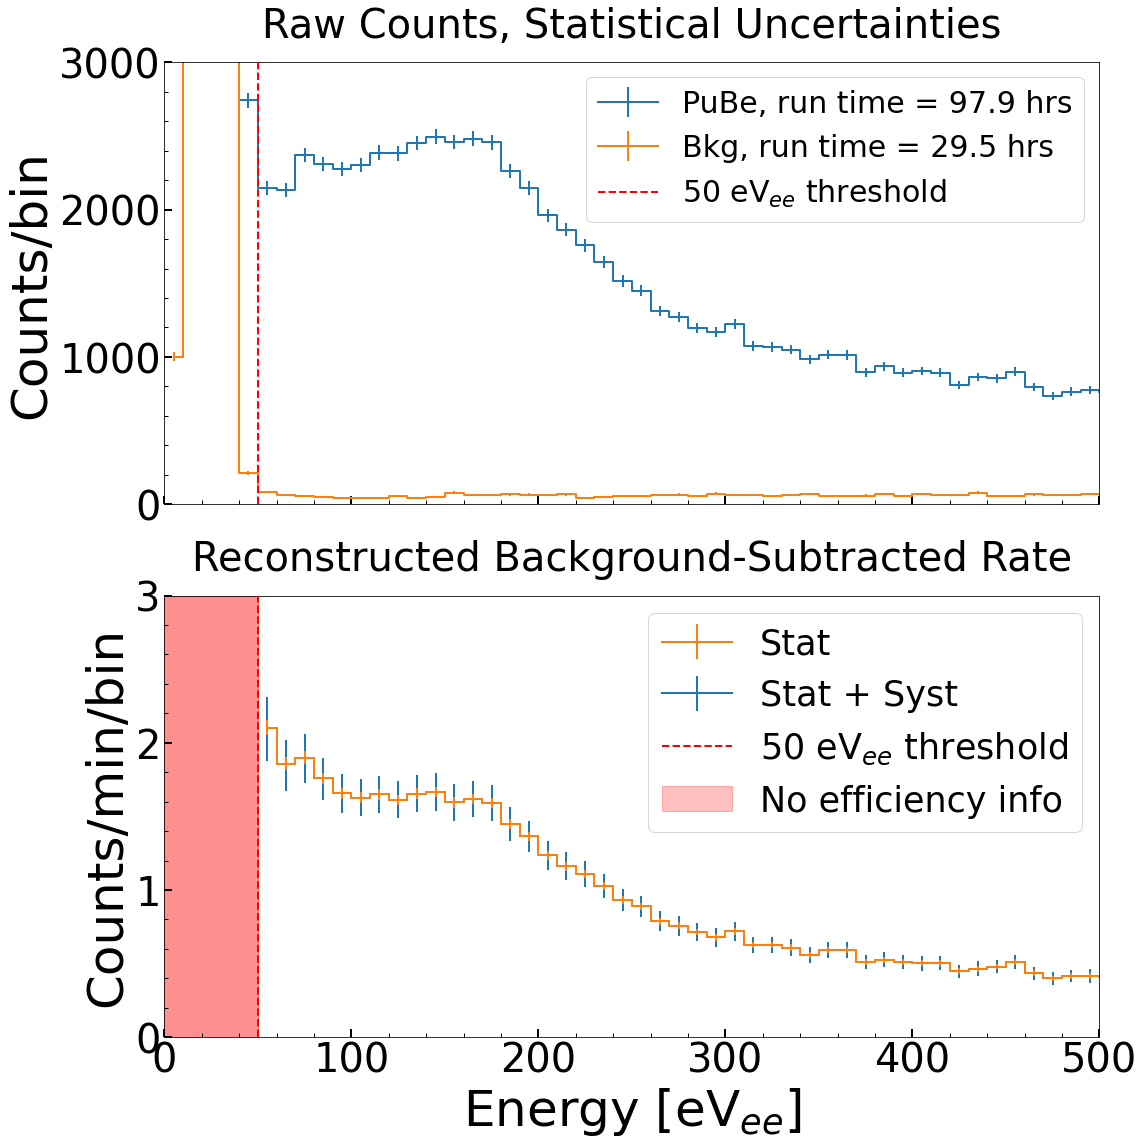

In [1]:
#Import libraries and settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
exec(open("../python/nb_setup.py").read())
from constants import *
import R68_load as r68
import R68_efficiencies as eff
meas=r68.load_measured()
import R68_spec_tools as spec
from matplotlib import *
style.use('../mplstyles/stylelib/standard.mplstyle')

#Turn off expected warnings
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore",category=RuntimeWarning)

fig_w=7 #Used later for figure width

# Binning setup
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2
Efit_min=50#[eVee]
Efit_max=1750#[eVee]
spec_bounds=(np.digitize(Efit_min,Ebins)-1,np.digitize(Efit_max,Ebins)-1)
Ebins_ctr[slice(*spec_bounds)].shape

#Measured
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)
#Count uncertainties are Poisson
dN_meas_PuBe_Pois=np.sqrt(N_meas_PuBe)
dN_meas_Bkg_Pois=np.sqrt(N_meas_Bkg)

#Include uncertainty from efficiencies
dN_meas_PuBe = N_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 + (eff.deff_write/eff.eff_write)**2 +
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2)
dN_meas_Bkg = N_meas_Bkg*np.sqrt( (dN_meas_Bkg_Pois/N_meas_Bkg)**2 + (eff.deff_write_bkg/eff.eff_write_bkg)**2 +
                                   (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
#Scaling factors
tlive_ratio=meas['PuBe']['tlive']/meas['Bkg']['tlive']
writeEff_ratio=eff.eff_write/eff.eff_write_bkg
dwriteEff_ratio=writeEff_ratio*np.sqrt( (eff.deff_write/eff.eff_write)**2 + (eff.deff_write_bkg/eff.eff_write_bkg)**2 )

cutEff_ratio=eff.cutEffFit(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr)
dcutEff_ratio = cutEff_ratio*np.sqrt( (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 + 
                                     (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 )

ratio=tlive_ratio*writeEff_ratio*cutEff_ratio
dratio=ratio*np.sqrt( (dwriteEff_ratio/writeEff_ratio)**2 +(dcutEff_ratio/cutEff_ratio)**2 )

#Make sure any divide by 0s happened below threshold
if (not np.all(np.isfinite(ratio[slice(*spec_bounds)]))) or (not np.all(np.isfinite(dratio[slice(*spec_bounds)]))):
    print('Error: Bad background scaling ratio in fit range.')

#Bkg-subtracted measured PuBe signal
N_bkg_scaled=N_meas_Bkg*ratio
dN_bkg_scaled=N_bkg_scaled*np.sqrt( (dN_meas_Bkg/N_meas_Bkg)**2 + (dratio/ratio)**2 )

N_meas = N_meas_PuBe - N_bkg_scaled
dN_meas = np.sqrt( dN_meas_PuBe**2 + dN_bkg_scaled**2 ) #All errors are symmetric here when using the conservative cut eff fits
dN_meas_stat = np.sqrt( dN_meas_PuBe_Pois**2 + (dN_meas_Bkg_Pois*ratio)**2 )

Denom_PuBe = meas['PuBe']['tlive']*eff.eff_write*eff.cutEffFit(Ebins_ctr)*eff.trigEff(Ebins_ctr)
R_meas_PuBe = N_meas_PuBe/Denom_PuBe
Denom_Bkg = meas['Bkg']['tlive']*eff.eff_write_bkg*eff.cutEffFit_bkg(Ebins_ctr)*eff.trigEff(Ebins_ctr)
R_meas_Bkg = N_meas_Bkg/Denom_Bkg

R_meas = R_meas_PuBe - R_meas_Bkg

dR_meas_stat_PuBe = R_meas_PuBe*dN_meas_PuBe_Pois/N_meas_PuBe
dR_meas_PuBe = R_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 +\
                                   (eff.deff_write/eff.eff_write)**2 +\
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 +\
                                   (eff.dtrigEff(Ebins_ctr)/eff.trigEff(Ebins_ctr))**2 )
dR_meas_stat_Bkg = R_meas_Bkg*dN_meas_Bkg_Pois/N_meas_Bkg
dR_meas_Bkg = R_meas_Bkg*np.sqrt( (dN_meas_Bkg_Pois/N_meas_Bkg)**2 +\
                                 (eff.deff_write_bkg/eff.eff_write_bkg)**2 +\
                                 (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
                                 (eff.dtrigEff(Ebins_ctr)/eff.trigEff(Ebins_ctr))**2 )

dR_meas_stat = np.sqrt(dR_meas_stat_PuBe**2 + dR_meas_stat_Bkg**2)
dR_meas = np.sqrt(dR_meas_PuBe**2 + dR_meas_Bkg**2)

c_stat,dc_stat=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=False, doBurstLeaksyst=False, output='counts')
c_syst,dc_syst=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=False, output='counts')
c_syst2,dc_syst2=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=True, output='counts')

r_stat,dr_stat=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=False, doBurstLeaksyst=False, output='reco-rate')
r_syst,dr_syst=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=False, output='reco-rate')
r_syst2,dr_syst2=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=True, output='reco-rate')

fig,ax = plt.subplots(2,1,sharex=True,figsize=(16,16))
fill_noise=ax[1].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)

cthresh=Ebins_ctr>=50 #Only plot hists above threshold

#Raw Count histograms
ax[0].set_title('Raw Counts, Statistical Uncertainties',size='40',pad='25')

line_c_PuBe=ax[0].errorbar(Ebins_ctr,N_meas_PuBe,yerr=dN_meas_PuBe_Pois, drawstyle = 'steps-mid', linewidth=2)
line_c_Bkg=ax[0].errorbar(Ebins_ctr,N_meas_Bkg,yerr=dN_meas_Bkg_Pois, drawstyle = 'steps-mid', linewidth=2)
line_thresh=ax[0].axvline(50,linestyle='--',color='r', label='50 eV$_{ee}$ threshold',zorder=5)

ax[0].set_xlim(0,5e2)
#ax[0].set_yscale('log')
ax[0].set_ylim(0,3e3)
ax[0].set_ylabel('Counts/bin')


ax[0].legend([line_c_PuBe, line_c_Bkg, line_thresh, fill_noise],
             [f"PuBe, run time = {meas['PuBe']['tlive']/3600:.1f} hrs",
              f"Bkg, run time = {meas['Bkg']['tlive']/3600:.1f} hrs",
              '50 eV$_{ee}$ threshold'],fontsize=30)
                                       
#Reconstructed rate
                                       
#Reverse errorbar order to be [lower,upper]
ax[1].set_title('Reconstructed Background-Subtracted Rate',size='40',pad='25')
line_r_syst=ax[1].errorbar(Ebins_ctr[cthresh],60*r_syst2[cthresh],yerr=(60*dr_syst2[::-1])[:,cthresh],drawstyle = 'steps-mid', linewidth=2, label='Stat + Syst')
line_r_stat=ax[1].errorbar(Ebins_ctr[cthresh],60*r_stat[cthresh],yerr=60*dr_stat[::-1][:,cthresh],drawstyle = 'steps-mid', linewidth=2, label='Stat')
                                       
line_thresh=ax[1].axvline(50,linestyle='--',color='r', label='50 eV$_{ee}$ threshold',zorder=5)
fill_noise=ax[1].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)
                                       
ax[1].legend([line_r_stat, line_r_syst, line_thresh, fill_noise],
             ['Stat', 'Stat + Syst', '50 eV$_{ee}$ threshold', 'No efficiency info'])
    
ax[1].set_ylim(0,3)
ax[1].set_xlim(0,500)
ax[1].set_ylabel('Counts/min/bin')
ax[1].set_xlabel('Energy [eV$_{ee}$]')


plt.tight_layout()
plt.savefig('../figures/meas_spec_reco_rate_pretty.pdf')
plt.show()

Overlaid  histograms  comparingthe  yielded  energy  PDFs  for  Sorensen and Lindhard models,
including the resolution of the current detector (see `Calibration.ipynb`).
The  histograms  are  comprised  of  approximately simulated cascades.
The orange (front) filled histogram represents  the  Lindhard  model  while  the  blue  (back)  filled histogram  represents  the  Sorensen  model.
In  the  Sorensen model,  many points are pushed to zero due to the presenceof a cutoff energy,
leading to a peak in the first bin that is not present in the Lindhard model.
For both models, we use k = 0.178, and for the Sorensen model, we use q= 0.00075.
The solid-line unfilled histogram represents the Lindhard model with one fifth of the detector’s resolution,
and the dashed unfilled histogram represents the Sorensen  model  with  one  fifth  of  the  detector’s  resolution.

This is not the data generated by Geant4 mentioned above, 
and is intended only to give an idea of what simulated data looks like. 
This data is instead generated using [a software package we developed for simulating nuclear recoils](https://github.com/villano-lab/nrCascadeSim).
This package does not assume any particular source and does not rely on the same assumptions as Geant4.

dict_keys(['xx', 'yy', 'ex', 'ey'])


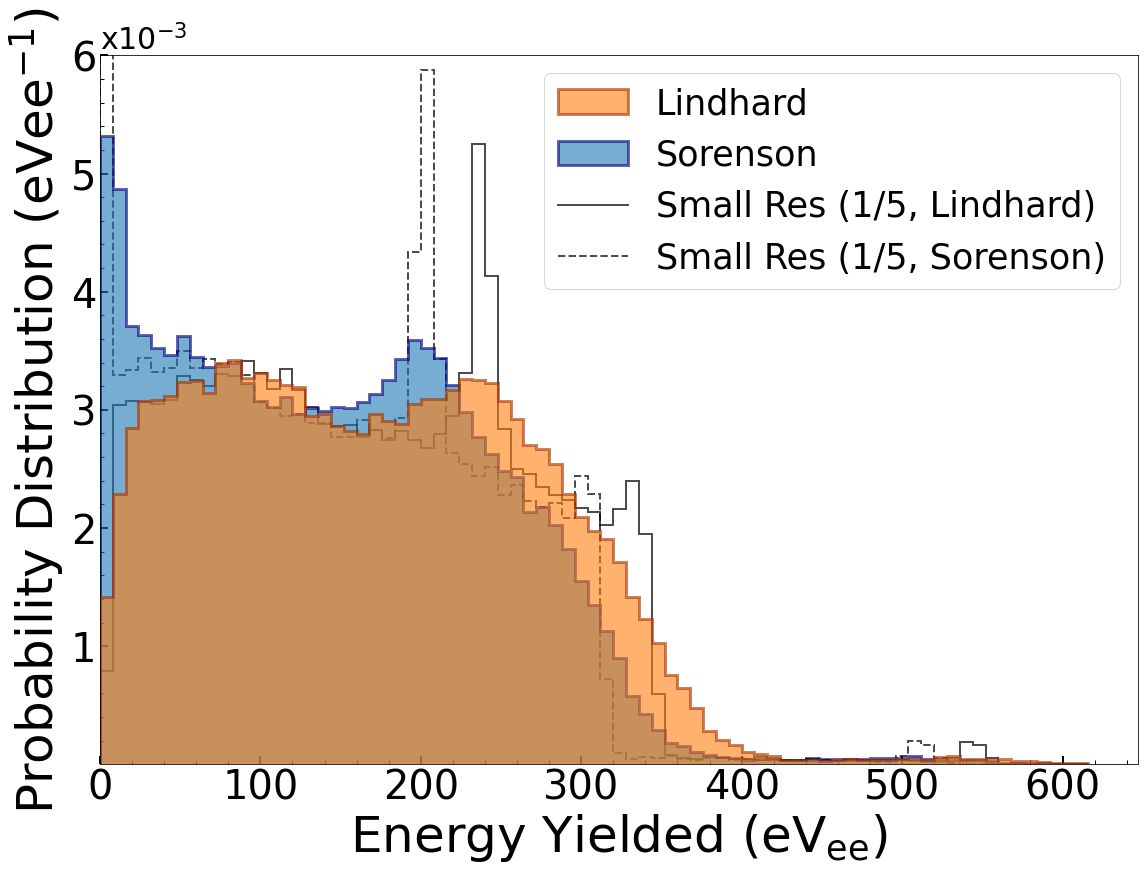

In [2]:
#Import Libraries
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
plt.style.use('../mplstyles/stylelib/standard.mplstyle')
from matplotlib.lines import Line2D
from tabulate import tabulate
import sys
sys.path.append('../python')
import nc_kinematics as nck
import lindhard as lin
import R68_yield as R68y
from histogram_utils import histogramable as h

#Select a file.
file = '../data/longsim.root'

#It's running, there's just a lot of data. Please be patient!

real_Lind = np.ndarray.flatten(np.asarray(h(file)[0]))
real_Sor = np.ndarray.flatten(np.asarray(h(file,model='Sorenson')[0]))
small_Lind = np.ndarray.flatten(np.asarray(h(file,scalefactor=0.2)[0]))
small_Sor = np.ndarray.flatten(np.asarray(h(file,model='Sorenson',scalefactor=0.2)[0]))

real_Lind = real_Lind[real_Lind >= 0]
real_Sor = real_Sor[real_Sor >= 0]
small_Lind = small_Lind[small_Lind >= 0]
small_Sor = small_Sor[small_Sor >= 0]

def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = np.float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

fig, ax = plt.subplots(figsize=(16,12))

binsize = 8 #bin width in eVee
bins = np.arange(0,620,binsize)

plt.hist(small_Lind,alpha=0.7,label='Small Res (1/5, Lindhard)',histtype='step',edgecolor='black',density='True',linewidth=2,bins=bins)
plt.hist(small_Sor,alpha=0.7,label='Small Res (1/5, Sorenson)',histtype='step',edgecolor='black',linestyle='--',density='True',linewidth=2,bins=bins)
plt.hist(real_Sor,alpha=0.6,label='Sorenson',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(real_Lind,alpha=0.6,label='Lindhard',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

plt.xlabel(r"Energy Yielded ($\mathrm{eV}_{\mathrm{ee}}$)")
plt.ylabel("Probability Distribution (eVee$^{-1}$)")#Counts/(total counts * bin width)")

ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major')

plt.xlim([0,None])
plt.ylim([6e-13,6e-3]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away

#Legend
LindPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='Lindhard',alpha=0.6)
SorPatch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Sorenson',alpha=0.6)
LindLine = Line2D([0],[0],alpha=0.7,color='black',label='Small Res (1/5, Lindhard)')
SorLine = Line2D([0],[0],linestyle='--',alpha=0.7,color='black',label='Small Res (1/5, Sorenson)')

plt.legend(handles=[LindPatch,SorPatch,LindLine,SorLine])
plt.savefig('../figures/SorVsLin.pdf')
plt.show()